In [1]:
val_csv_path = '/kaggle/input/iiit-hyd-smai-project-dataset/labels_val.csv'
train_csv_path = '/kaggle/input/iiit-hyd-smai-project-dataset/labels_train.csv'
train_img_dir = '/kaggle/input/iiit-hyd-smai-project-dataset/images_train'
val_img_dir = '/kaggle/input/iiit-hyd-smai-project-dataset/images_val'
test_img_dir = '/kaggle/input/iiit-hyd-smai-project-dataset/images_test'

# Output files will be written to the working directory
lat_long_output_csv = '/kaggle/working/lat-long.csv'
region_output_csv = '/kaggle/working/region.csv'
angle_output_csv = '/kaggle/working/angle.csv'
print(val_csv_path)

/kaggle/input/iiit-hyd-smai-project-dataset/labels_val.csv


In [2]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)
import timm

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s] 


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"💻 Using device: {device}")

💻 Using device: cuda


In [14]:
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
test_transform = val_transform

In [15]:
class CompassDataset(Dataset):
    def __init__(self, img_dir, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform
        angles_rad = np.deg2rad(self.df['angle'].astype(float).values)
        self.sin_targets = np.sin(angles_rad)
        self.cos_targets = np.cos(angles_rad)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        target = torch.tensor([self.sin_targets[idx], self.cos_targets[idx]], dtype=torch.float32)
        return image, target

class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.filenames = sorted(os.listdir(img_dir))
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.filenames[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

🔍 Original rows: 6467
✅ Rows after cleaning: 6263
❌ Total rows removed: 204


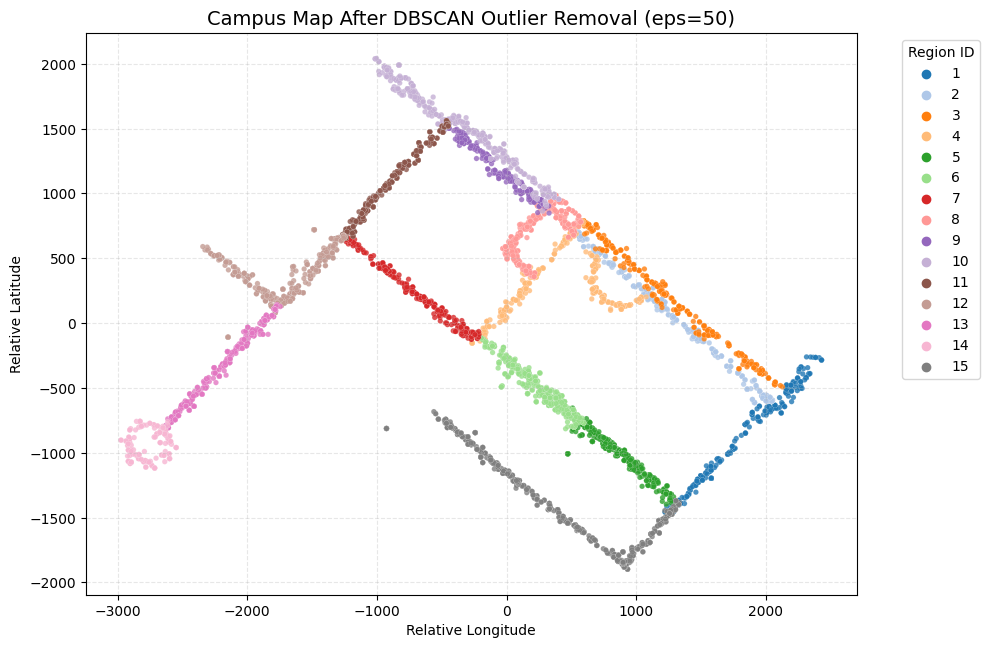

✅ Cleaned dataset saved as 'cleaned_train.csv'


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# --- Step 1: Load training data ---
df_train = pd.read_csv(train_csv_path)

# --- Step 2: Remove global outliers using IQR filtering ---
Q1_lat = df_train['latitude'].quantile(0.25)
Q3_lat = df_train['latitude'].quantile(0.75)
IQR_lat = Q3_lat - Q1_lat

Q1_lon = df_train['longitude'].quantile(0.25)
Q3_lon = df_train['longitude'].quantile(0.75)
IQR_lon = Q3_lon - Q1_lon

df_filtered = df_train[
    (df_train['latitude'] >= Q1_lat - 1.5 * IQR_lat) & (df_train['latitude'] <= Q3_lat + 1.5 * IQR_lat) &
    (df_train['longitude'] >= Q1_lon - 1.5 * IQR_lon) & (df_train['longitude'] <= Q3_lon + 1.5 * IQR_lon)
].copy()

# --- Step 3: Center coordinates for clustering ---
lat_mean = df_filtered['latitude'].mean()
lon_mean = df_filtered['longitude'].mean()
df_filtered['lat_centered'] = df_filtered['latitude'] - lat_mean
df_filtered['lon_centered'] = df_filtered['longitude'] - lon_mean

# --- Step 4: Region-wise DBSCAN for fine-grained outlier removal ---
def remove_outliers_regionwise(df, eps=50, min_samples=5):
    cleaned = []
    stats = []

    for region_id in sorted(df['Region_ID'].unique()):
        region_df = df[df['Region_ID'] == region_id].copy()
        coords = region_df[['lon_centered', 'lat_centered']].values

        db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
        region_df['cluster'] = db.labels_

        # Statistics
        total = len(region_df)
        kept = (region_df['cluster'] != -1).sum()
        removed = (region_df['cluster'] == -1).sum()

        stats.append({
            'Region_ID': region_id,
            'Original': total,
            'Kept': kept,
            'Removed': removed,
            'Percent_Removed': round(100 * removed / total, 2)
        })

        region_df = region_df[region_df['cluster'] != -1]
        cleaned.append(region_df)

    clean_df = pd.concat(cleaned, ignore_index=True)
    stats_df = pd.DataFrame(stats)

    return clean_df, stats_df

# --- Step 5: Run DBSCAN Cleaning ---
df_cleaned, stats_df = remove_outliers_regionwise(df_filtered, eps=50, min_samples=5)
print(f"🔍 Original rows: {len(df_filtered)}")
print(f"✅ Rows after cleaning: {len(df_cleaned)}")
print(f"❌ Total rows removed: {len(df_filtered) - len(df_cleaned)}")

# --- Step 6: Plot Cleaned Data ---
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_cleaned,
    x='lon_centered',
    y='lat_centered',
    hue='Region_ID',
    palette='tab20',
    s=15,
    linewidth=0.1,
    alpha=0.8
)
plt.title("Campus Map After DBSCAN Outlier Removal (eps=50)", fontsize=14)
plt.xlabel("Relative Longitude")
plt.ylabel("Relative Latitude")
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Region ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Step 7: Final Data Cleanup ---
# Drop duplicates and rows with missing essential values
df_cleaned.drop_duplicates(inplace=True)
df_cleaned.dropna(subset=['filename', 'timestamp', 'latitude', 'longitude', 'angle', 'Region_ID'], inplace=True)


# --- Step 8: Export cleaned dataset in required format ---
required_columns = ['filename', 'timestamp', 'latitude', 'longitude', 'angle', 'Region_ID']
df_final = df_cleaned[required_columns].copy()

df_final.to_csv("/kaggle/working/cleaned_train.csv", index=False)
print("✅ Cleaned dataset saved as 'cleaned_train.csv'")
train_csv_path = '/kaggle/working/cleaned_train.csv'

In [23]:
train_dataset = CompassDataset(train_img_dir, train_csv_path, transform=train_transform)
val_dataset = CompassDataset(val_img_dir, val_csv_path, transform=val_transform)
test_dataset = TestDataset(test_img_dir, transform=val_transform)
print(train_csv_path)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

/kaggle/working/cleaned_train.csv


In [24]:
model = timm.create_model('efficientnet_b0', pretrained=True)
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, 2)
if hasattr(model, 'gradient_checkpointing_enable'):
    model.gradient_checkpointing_enable()

model = model.to(device)

def circular_mae(pred, target):
    ang_pred = torch.atan2(pred[:, 0], pred[:, 1]) * (180.0 / np.pi)
    ang_true = torch.atan2(target[:, 0], target[:, 1]) * (180.0 / np.pi)
    diff = torch.abs(ang_pred - ang_true)
    return torch.min(diff, 360.0 - diff).mean()


def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for imgs, tgt in loader:
            imgs, tgt = imgs.to(device, non_blocking=True), tgt.to(device, non_blocking=True)
            preds = model(imgs)
            total_loss += circular_mae(preds, tgt).item() * imgs.size(0)
    return total_loss / len(loader.dataset)


def train_model(model, train_loader, val_loader, device, head_epochs=10, ft_epochs=50, head_lr=1e-3, ft_lr=1e-4, batch_accum=2, patience=5):
    scaler = torch.cuda.amp.GradScaler()
    best_loss = float('inf')
    best_state_dict = None

    # Stage 1: Train head
    for name, param in model.named_parameters():
        param.requires_grad = ('classifier' in name)
    opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=head_lr)

    for epoch in range(head_epochs):
        model.train()
        loop = tqdm(train_loader, desc=f"Head Epoch {epoch+1}/{head_epochs}")
        step = 0
        opt.zero_grad()
        for imgs, tgt in loop:
            imgs, tgt = imgs.to(device), tgt.to(device)
            with torch.cuda.amp.autocast():
                preds = model(imgs)
                loss = circular_mae(preds, tgt) / batch_accum
            scaler.scale(loss).backward()
            if (step + 1) % batch_accum == 0:
                scaler.step(opt)
                scaler.update()
                opt.zero_grad()
            loop.set_postfix(loss=loss.item() * batch_accum)
            step += 1
        val_loss = evaluate(model, val_loader, device)
        print(f"→ [Head] Val MAE: {val_loss:.2f}°")
        if val_loss < best_loss:
            best_loss = val_loss
            best_state_dict = model.state_dict()

    # Stage 2: Fine-tune all with Early Stopping
    for param in model.parameters():
        param.requires_grad = True
    opt = torch.optim.Adam(model.parameters(), lr=ft_lr)

    no_improve_epochs = 0
    for epoch in range(ft_epochs):
        model.train()
        loop = tqdm(train_loader, desc=f"FT Epoch {epoch+1}/{ft_epochs}")
        step = 0
        total_train_loss = 0.0
        opt.zero_grad()
        for imgs, tgt in loop:
            imgs, tgt = imgs.to(device), tgt.to(device)
            with torch.cuda.amp.autocast():
                preds = model(imgs)
                loss_batch = circular_mae(preds, tgt)
                loss = loss_batch / batch_accum
            scaler.scale(loss).backward()
            if (step + 1) % batch_accum == 0:
                scaler.step(opt)
                scaler.update()
                opt.zero_grad()
            loop.set_postfix(loss=loss_batch.item())
            total_train_loss += loss_batch.item() * imgs.size(0)
            step += 1
        train_mae = total_train_loss / len(train_loader.dataset)
        val_loss = evaluate(model, val_loader, device)
        print(f"→ [FT] Train MAE: {train_mae:.2f}°, Val MAE: {val_loss:.2f}°")

        if val_loss < best_loss:
            best_loss = val_loss
            best_state_dict = model.state_dict()

    # Save best model
    if best_state_dict:
        torch.save(best_state_dict, 'best_model.pt')
        print(f"💾 Saved best model with Val MAE: {best_loss:.2f}° → best_model.pt")
    else:
        print("⚠️ No model was saved (no improvement observed during training).")


train_model(model, train_loader, val_loader, device)


/tmp/ipykernel_32/1604144113.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Head Epoch 1/10:   0%|          | 0/392 [00:00<?, ?it/s]/tmp/ipykernel_32/1604144113.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Head Epoch 1/10: 100%|██████████| 392/392 [00:33<00:00, 11.62it/s, loss=97.4]


→ [Head] Val MAE: 80.32°


Head Epoch 2/10: 100%|██████████| 392/392 [00:29<00:00, 13.21it/s, loss=104] 


→ [Head] Val MAE: 78.11°


Head Epoch 3/10: 100%|██████████| 392/392 [00:29<00:00, 13.23it/s, loss=112] 


→ [Head] Val MAE: 77.13°


Head Epoch 4/10: 100%|██████████| 392/392 [00:30<00:00, 13.01it/s, loss=58.5]


→ [Head] Val MAE: 76.12°


Head Epoch 5/10: 100%|██████████| 392/392 [00:30<00:00, 12.99it/s, loss=62.6]


→ [Head] Val MAE: 78.11°


Head Epoch 6/10: 100%|██████████| 392/392 [00:30<00:00, 13.03it/s, loss=33.3]


→ [Head] Val MAE: 74.60°


Head Epoch 7/10: 100%|██████████| 392/392 [00:29<00:00, 13.22it/s, loss=74.2]


→ [Head] Val MAE: 72.50°


Head Epoch 8/10: 100%|██████████| 392/392 [00:29<00:00, 13.13it/s, loss=76.5]


→ [Head] Val MAE: 73.69°


Head Epoch 9/10: 100%|██████████| 392/392 [00:29<00:00, 13.44it/s, loss=66.2]


→ [Head] Val MAE: 73.69°


Head Epoch 10/10: 100%|██████████| 392/392 [00:29<00:00, 13.30it/s, loss=37.7]


→ [Head] Val MAE: 74.17°


FT Epoch 1/50:   0%|          | 0/392 [00:00<?, ?it/s]/tmp/ipykernel_32/1604144113.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
FT Epoch 1/50: 100%|██████████| 392/392 [00:31<00:00, 12.39it/s, loss=69.4]


→ [FT] Train MAE: 68.12°, Val MAE: 70.04°


FT Epoch 2/50: 100%|██████████| 392/392 [00:31<00:00, 12.29it/s, loss=58.2]


→ [FT] Train MAE: 61.22°, Val MAE: 66.84°


FT Epoch 3/50: 100%|██████████| 392/392 [00:31<00:00, 12.41it/s, loss=74]  


→ [FT] Train MAE: 58.70°, Val MAE: 62.93°


FT Epoch 4/50: 100%|██████████| 392/392 [00:32<00:00, 12.18it/s, loss=46.3]


→ [FT] Train MAE: 53.78°, Val MAE: 59.84°


FT Epoch 5/50: 100%|██████████| 392/392 [00:32<00:00, 12.16it/s, loss=33.7]


→ [FT] Train MAE: 51.12°, Val MAE: 57.12°


FT Epoch 6/50: 100%|██████████| 392/392 [00:32<00:00, 12.04it/s, loss=20.4]


→ [FT] Train MAE: 47.18°, Val MAE: 55.15°


FT Epoch 7/50: 100%|██████████| 392/392 [00:32<00:00, 11.91it/s, loss=43.5]


→ [FT] Train MAE: 44.63°, Val MAE: 51.48°


FT Epoch 8/50: 100%|██████████| 392/392 [00:32<00:00, 11.94it/s, loss=55.1]


→ [FT] Train MAE: 40.91°, Val MAE: 52.84°


FT Epoch 9/50: 100%|██████████| 392/392 [00:33<00:00, 11.77it/s, loss=54.9]


→ [FT] Train MAE: 39.72°, Val MAE: 51.68°


FT Epoch 10/50: 100%|██████████| 392/392 [00:32<00:00, 12.16it/s, loss=45]  


→ [FT] Train MAE: 37.19°, Val MAE: 48.94°


FT Epoch 11/50: 100%|██████████| 392/392 [00:32<00:00, 11.98it/s, loss=43.3]


→ [FT] Train MAE: 38.63°, Val MAE: 48.21°


FT Epoch 12/50: 100%|██████████| 392/392 [00:32<00:00, 12.17it/s, loss=43.5]


→ [FT] Train MAE: 35.52°, Val MAE: 47.70°


FT Epoch 13/50: 100%|██████████| 392/392 [00:33<00:00, 11.85it/s, loss=43.4]


→ [FT] Train MAE: 32.65°, Val MAE: 48.51°


FT Epoch 14/50: 100%|██████████| 392/392 [00:32<00:00, 12.13it/s, loss=18.5]


→ [FT] Train MAE: 30.86°, Val MAE: 46.63°


FT Epoch 15/50: 100%|██████████| 392/392 [00:32<00:00, 11.96it/s, loss=57.2]


→ [FT] Train MAE: 28.90°, Val MAE: 44.88°


FT Epoch 16/50: 100%|██████████| 392/392 [00:32<00:00, 11.88it/s, loss=30.1]


→ [FT] Train MAE: 26.75°, Val MAE: 44.06°


FT Epoch 17/50: 100%|██████████| 392/392 [00:33<00:00, 11.86it/s, loss=35.5]


→ [FT] Train MAE: 26.20°, Val MAE: 41.73°


FT Epoch 18/50: 100%|██████████| 392/392 [00:32<00:00, 11.93it/s, loss=33.4]


→ [FT] Train MAE: 28.23°, Val MAE: 44.99°


FT Epoch 19/50: 100%|██████████| 392/392 [00:32<00:00, 12.14it/s, loss=22.9]


→ [FT] Train MAE: 27.19°, Val MAE: 43.33°


FT Epoch 20/50: 100%|██████████| 392/392 [00:32<00:00, 12.09it/s, loss=49.2]


→ [FT] Train MAE: 24.84°, Val MAE: 39.79°


FT Epoch 21/50: 100%|██████████| 392/392 [00:32<00:00, 11.96it/s, loss=18.3]


→ [FT] Train MAE: 23.64°, Val MAE: 39.59°


FT Epoch 22/50: 100%|██████████| 392/392 [00:32<00:00, 11.92it/s, loss=17.8]


→ [FT] Train MAE: 22.27°, Val MAE: 39.88°


FT Epoch 23/50: 100%|██████████| 392/392 [00:32<00:00, 12.04it/s, loss=15.1]


→ [FT] Train MAE: 20.90°, Val MAE: 38.77°


FT Epoch 24/50: 100%|██████████| 392/392 [00:32<00:00, 12.13it/s, loss=27.8]


→ [FT] Train MAE: 20.75°, Val MAE: 38.01°


FT Epoch 25/50: 100%|██████████| 392/392 [00:32<00:00, 12.06it/s, loss=40.1]


→ [FT] Train MAE: 19.30°, Val MAE: 37.76°


FT Epoch 26/50: 100%|██████████| 392/392 [00:32<00:00, 11.94it/s, loss=24.2]


→ [FT] Train MAE: 19.92°, Val MAE: 37.79°


FT Epoch 27/50: 100%|██████████| 392/392 [00:32<00:00, 11.94it/s, loss=36.6]


→ [FT] Train MAE: 19.02°, Val MAE: 38.07°


FT Epoch 28/50: 100%|██████████| 392/392 [00:33<00:00, 11.70it/s, loss=44.6]


→ [FT] Train MAE: 18.48°, Val MAE: 38.61°


FT Epoch 29/50: 100%|██████████| 392/392 [00:32<00:00, 11.92it/s, loss=19.4]


→ [FT] Train MAE: 17.72°, Val MAE: 36.25°


FT Epoch 30/50: 100%|██████████| 392/392 [00:32<00:00, 11.99it/s, loss=30.3]


→ [FT] Train MAE: 17.22°, Val MAE: 36.93°


FT Epoch 31/50: 100%|██████████| 392/392 [00:32<00:00, 12.12it/s, loss=21.7]


→ [FT] Train MAE: 17.11°, Val MAE: 36.10°


FT Epoch 32/50: 100%|██████████| 392/392 [00:33<00:00, 11.75it/s, loss=35.5]


→ [FT] Train MAE: 16.28°, Val MAE: 36.42°


FT Epoch 33/50: 100%|██████████| 392/392 [00:32<00:00, 12.03it/s, loss=15.1]


→ [FT] Train MAE: 15.90°, Val MAE: 36.51°


FT Epoch 34/50: 100%|██████████| 392/392 [00:33<00:00, 11.77it/s, loss=21.3]


→ [FT] Train MAE: 15.81°, Val MAE: 37.04°


FT Epoch 35/50: 100%|██████████| 392/392 [00:32<00:00, 11.98it/s, loss=15.2]


→ [FT] Train MAE: 15.57°, Val MAE: 36.97°


FT Epoch 36/50: 100%|██████████| 392/392 [00:32<00:00, 12.21it/s, loss=26.1]


→ [FT] Train MAE: 15.34°, Val MAE: 36.97°


FT Epoch 37/50: 100%|██████████| 392/392 [00:33<00:00, 11.72it/s, loss=16]  


→ [FT] Train MAE: 15.35°, Val MAE: 37.01°


FT Epoch 38/50: 100%|██████████| 392/392 [00:32<00:00, 11.91it/s, loss=20.4]


→ [FT] Train MAE: 14.07°, Val MAE: 36.93°


FT Epoch 39/50: 100%|██████████| 392/392 [00:33<00:00, 11.86it/s, loss=29.1]


→ [FT] Train MAE: 14.28°, Val MAE: 35.82°


FT Epoch 40/50: 100%|██████████| 392/392 [00:33<00:00, 11.79it/s, loss=19.1]


→ [FT] Train MAE: 13.74°, Val MAE: 35.32°


FT Epoch 41/50: 100%|██████████| 392/392 [00:33<00:00, 11.81it/s, loss=29.9]


→ [FT] Train MAE: 13.87°, Val MAE: 36.05°


FT Epoch 42/50: 100%|██████████| 392/392 [00:33<00:00, 11.80it/s, loss=14.5]


→ [FT] Train MAE: 13.53°, Val MAE: 35.62°


FT Epoch 43/50: 100%|██████████| 392/392 [00:33<00:00, 11.85it/s, loss=19.3]


→ [FT] Train MAE: 13.04°, Val MAE: 35.83°


FT Epoch 44/50: 100%|██████████| 392/392 [00:32<00:00, 11.98it/s, loss=13.8]


→ [FT] Train MAE: 12.86°, Val MAE: 34.76°


FT Epoch 45/50: 100%|██████████| 392/392 [00:32<00:00, 11.95it/s, loss=10.3]


→ [FT] Train MAE: 13.07°, Val MAE: 34.11°


FT Epoch 46/50: 100%|██████████| 392/392 [00:33<00:00, 11.83it/s, loss=14.4]


→ [FT] Train MAE: 12.80°, Val MAE: 33.27°


FT Epoch 47/50: 100%|██████████| 392/392 [00:32<00:00, 11.96it/s, loss=12.1]


→ [FT] Train MAE: 13.50°, Val MAE: 35.73°


FT Epoch 48/50: 100%|██████████| 392/392 [00:32<00:00, 11.99it/s, loss=21.7]


→ [FT] Train MAE: 12.61°, Val MAE: 34.04°


FT Epoch 49/50: 100%|██████████| 392/392 [00:32<00:00, 11.91it/s, loss=20]  


→ [FT] Train MAE: 12.18°, Val MAE: 34.60°


FT Epoch 50/50: 100%|██████████| 392/392 [00:32<00:00, 12.06it/s, loss=13.8]


→ [FT] Train MAE: 11.52°, Val MAE: 33.56°
💾 Saved best model with Val MAE: 33.27° → best_model.pt


In [25]:
def predict_angles(model, loader, device):
    model.eval()
    preds_final = []
    with torch.no_grad():
        for batch in loader:
            imgs = batch[0] if isinstance(batch, (tuple, list)) else batch
            imgs = imgs.to(device)
            preds = model(imgs)
            sin = preds[:, 0]
            cos = preds[:, 1]
            ang = torch.atan2(sin, cos) * (180.0 / np.pi)
            ang = ang % 360
            preds_final.extend(ang.cpu().numpy().tolist())
    return preds_final

def generate_submission(model, val_loader, test_loader, device, output_csv="name_of_output_file.csv"):
    model.load_state_dict(torch.load("best_model.pt", map_location=device))
    
    val_preds = predict_angles(model, val_loader, device)
    test_preds = predict_angles(model, test_loader, device)

    all_preds = val_preds + test_preds
    all_preds = [int(round(x)) for x in all_preds]
    ids = list(range(len(all_preds)))

    df = pd.DataFrame({"id": ids, "angle": all_preds})
    df.to_csv(output_csv, index=False)
    print(f"✅ Saved full submission with {len(df)} rows to {output_csv}")

generate_submission(model, val_loader, test_loader, device, output_csv='2022101005_5.csv')

/tmp/ipykernel_32/2854747754.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt", map_location=device))


✅ Saved full submission with 738 rows to 2022101001_5.csv
